# Classical methods in order to detect schizophrenia with EEG dataset

## Imports

In [48]:
import os
import mne
import numpy as np

import scipy.stats as stats

from mne.filter import construct_iir_filter
from mne.preprocessing import ICA
from mne.io import RawArray

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier

from tools.eegPowerBand import eeg_power_band
from tools.MNEtoXYSets import transform

from statsmodels.tsa.ar_model import AutoReg

## Loading EEG raw data

In [2]:
def load_edf():
    edfs_path = "..\dataverse_files"
    manifest_path = "..\dataverse_files\MANIFEST.txt"

    raw_patients_data = []
    edfs_file_names = [f for f in os.listdir(edfs_path) if f.endswith('.edf')]

    for file_name in edfs_file_names:
        path = edfs_path + '\\' + file_name 
        raw_data = mne.io.read_raw_edf(path, preload=True, verbose=False)
        raw_patients_data.append(raw_data)

    return raw_patients_data

## Preprocessing

#### Preprocessing with filtering (Butterworth lowpass filter 6th order with fcut=50Hz)

In [61]:
def preprocessing_by_filtering(order, f_pass, f_stop, filter_type):
    raw_patients_data = load_edf()
    # iir_filter = construct_iir_filter(dict(order=order, ftype='butter', output='sos'), 50, None, 250, 'low', verbose=False)
    iir_filter = construct_iir_filter(dict(order=order, ftype='butter', output='sos'), f_pass, f_stop, 250, filter_type, verbose=False)

    return [ raw_patient_data
                .filter(l_freq=None, h_freq=None, picks='eeg', method='iir', iir_params=iir_filter, n_jobs=-1, verbose=False) 
            for raw_patient_data in raw_patients_data ]

#### Preprocessing with ICA

##### FASTICA From MNE

In [4]:
def preprocessing_by_MNE_ICA():
    fitted_patients_data = []
    ica_patients_data = []
    raw_patients_data = load_edf()
    # Optimalization for ICA
    ica_raw_patients_data = [raw_patient_data.copy().filter(l_freq=1., h_freq=None, verbose = False) for raw_patient_data in raw_patients_data]

    for ica_raw_patient_data in ica_raw_patients_data:
        ica = ICA(verbose = False)
        tmp = ica.fit(ica_raw_patient_data, verbose = False)
        fitted_patients_data.append(tmp.get_sources(ica_raw_patient_data))

    for index, ica_feature in enumerate(fitted_patients_data):
        ica_patients_data.append(RawArray(ica_feature.get_data(), raw_patients_data[index].info, verbose=False))

    return ica_patients_data

##### FASTICA from sklearn

In [62]:
def preprocessing_by_sklearn_ICA(feature):    
    fastICA = FastICA(whiten='unit-variance')
    raw_patients_data = load_edf()
    fastICAfeatures = [raw_patient_data.copy().get_data() for raw_patient_data in raw_patients_data]
    fastica_patients_data = []

    for index, patient in enumerate(raw_patients_data):
        fastICA.fit(patient.get_data()[:-1].reshape(-1, 1))
        fastICAfeatures[index][feature] = fastICA.transform(patient.get_data()[feature].reshape(-1, 1)).reshape(1, -1)

    for index, fastICAfeature in enumerate(fastICAfeatures):
        fastica_patients_data.append(RawArray(fastICAfeature, raw_patients_data[index].info, verbose=False))
        
    return fastica_patients_data

## Transform MNE data to features and label arrays

In [64]:
raw_patients_data = load_edf()
edf_file = [raw_patient_data.filenames[0] for raw_patient_data in raw_patients_data]

X1, y = transform(preprocessing_by_filtering(6, 50, None, 'low'))
X2, _ = transform(preprocessing_by_MNE_ICA(), edf_file = edf_file)
X3, _ = transform(preprocessing_by_sklearn_ICA(-5), edf_file = edf_file)

Not setting metadata
1142 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
1142 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
1142 matching events found
No baseline correction applied
0 bad epochs dropped


## Extraction

#### Energy band

In [ ]:
eeg_power_band(X3)

Effective window size : 1.024 (s)


array([[0.01444201, 0.04726728, 0.02694228, ..., 0.00893181, 0.01157394,
        0.00626317],
       [0.01321205, 0.0394069 , 0.0193071 , ..., 0.00290284, 0.0104067 ,
        0.01054607],
       [0.02046477, 0.02646721, 0.02150678, ..., 0.01551786, 0.00866768,
        0.00887361],
       ...,
       [0.07770498, 0.07000848, 0.11983613, ..., 0.00608645, 0.00559372,
        0.00527811],
       [0.0416986 , 0.03433957, 0.03470014, ..., 0.00664178, 0.00506852,
        0.00427559],
       [0.05974039, 0.03806375, 0.05428016, ..., 0.00596308, 0.00516729,
        0.00269637]])

#### Variance

In [8]:
def variance_extraction(data):
    featuresVar = []
    for index, feature in enumerate(data.get_data()):
        featuresVar.append(np.var(feature, axis = 1))

    return np.array(featuresVar)

#### Autoregression

In [9]:
def autoregresion_extraction(data):
    featuresVar = []
    for patient in data:
        patient_arr = []
        for electrode in patient:
            model = AutoReg(electrode, lags=10)
            result = model.fit()
            patient_arr.append(result.params.flatten())
        featuresVar.append(patient_arr)

    for index, el in enumerate(featuresVar):
        featuresVar[index] = np.array(el).flatten()

    return np.array(featuresVar)

#### L1 Norm

In [10]:
def l1norm_extraction(data):
    featuresVar = []
    for index, feature in enumerate(data.get_data()):
        featuresVar.append(np.linalg.norm(feature, ord = 1, axis = 1))

    return np.array(featuresVar)

## Selection

#### _t-test Welch (rank method)_

In [11]:
def t_stats_selection(X, y, features=10):
    tstat = np.abs(stats.ttest_ind(X, y, equal_var = False).statistic)
    ind = np.argpartition(tstat, -features)[-features:]

    return X[:,ind]

#### _PCA_

In [12]:
def pca_selection(X, y, n_components=5):
    pca = PCA(n_components)
    return pca.fit_transform(X, y)

#### _SFS_

In [13]:
def sfs_selection(X, y, n_features = 5):
    lda = LinearDiscriminantAnalysis(solver='lsqr')
    sfs = SequentialFeatureSelector(lda, n_features_to_select = n_features)
    return sfs.fit_transform(X, y)

## Dataset split

In [89]:
X_train, X_test, y_train, y_test = train_test_split(t_stats_selection(eeg_power_band(X2), y, 18), y, test_size=0.2, shuffle=True)

Effective window size : 1.024 (s)


## Classification

In [85]:
def classification(estimator, X_train, X_test, y_train, y_test, **args):
    clr = estimator(**args)
    clr.fit(X_train, y_train)
    y_pred = clr.predict(X_test)
    print(f"{estimator().__class__.__name__} - Params: {args}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    print(f"ACC: {clr.score(X_test, y_test)}")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    RocCurveDisplay.from_predictions(y_test, y_pred)

#### KNN

KNeighborsClassifier - Params: {}
F1 Score: 0.9718875502008033
ACC: 0.9694323144104804


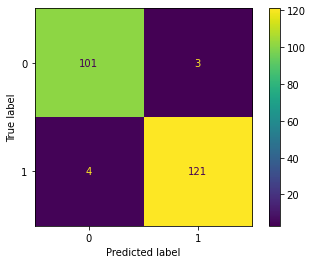

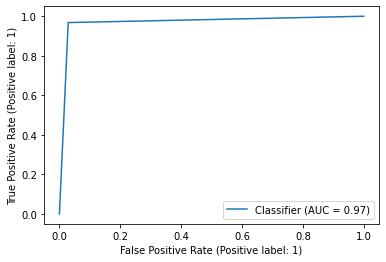

In [91]:
classification(KNeighborsClassifier, X_train, X_test, y_train, y_test)

#### LDA

LinearDiscriminantAnalysis - Params: {'solver': 'lsqr'}
F1 Score: 0.8171206225680934
ACC: 0.7947598253275109


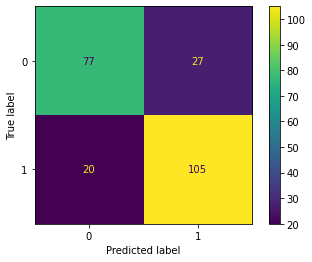

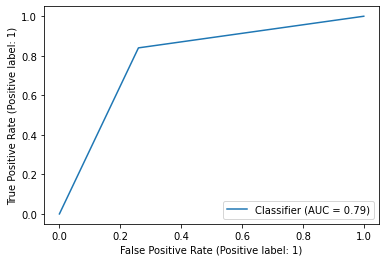

In [92]:
classification(LinearDiscriminantAnalysis, X_train, X_test, y_train, y_test, solver='lsqr')

#### QDA

QuadraticDiscriminantAnalysis - Params: {}
F1 Score: 0.9067796610169492
ACC: 0.9039301310043668


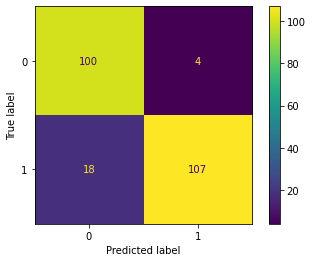

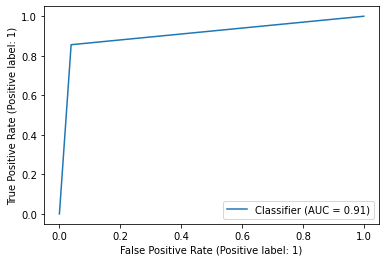

In [93]:
classification(QuadraticDiscriminantAnalysis, X_train, X_test, y_train, y_test)

#### SVC

SVC - Params: {'kernel': 'linear'}
F1 Score: 0.7062146892655368
ACC: 0.5458515283842795
SVC - Params: {'kernel': 'poly'}
F1 Score: 0.9512195121951219
ACC: 0.9475982532751092
SVC - Params: {'kernel': 'rbf'}
F1 Score: 0.9561752988047808
ACC: 0.9519650655021834
SVC - Params: {'kernel': 'sigmoid'}
F1 Score: 0.5627376425855514
ACC: 0.4978165938864629


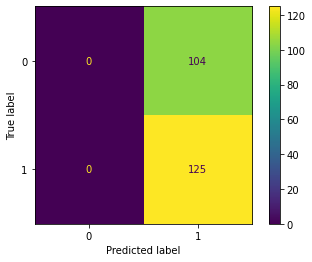

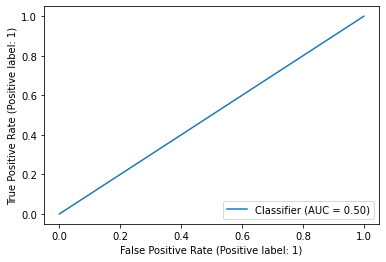

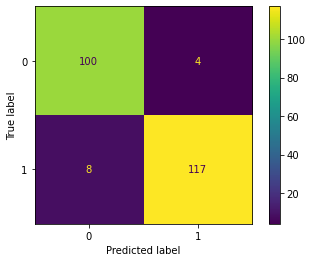

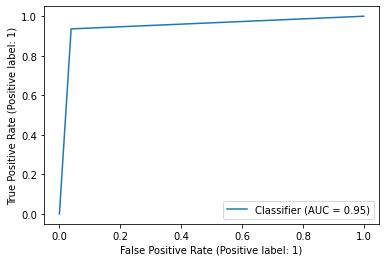

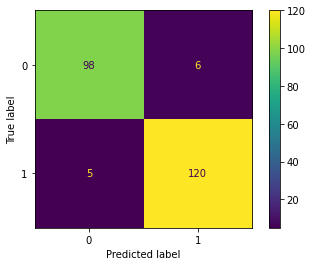

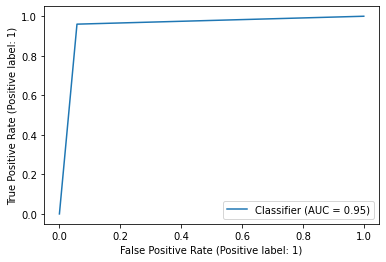

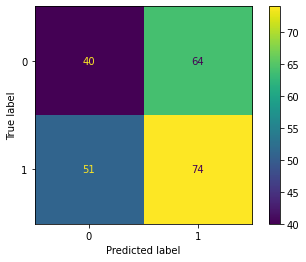

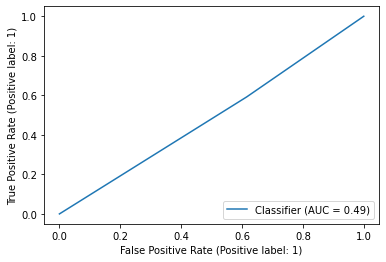

In [94]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    classification(SVC, X_train, X_test, y_train, y_test, kernel=kernel)

#### DecisionTreeClassifier

DecisionTreeClassifier - Params: {}
F1 Score: 0.9019607843137256
ACC: 0.8908296943231441


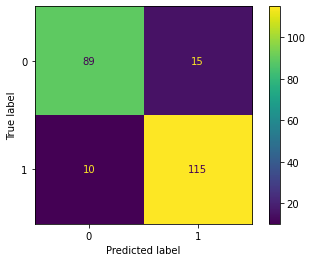

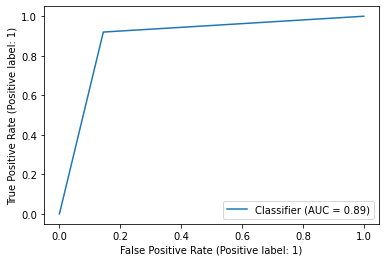

In [95]:
classification(DecisionTreeClassifier, X_train, X_test, y_train, y_test)
